## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/)) <font size='3ptx'>**Model averaging is an ensemble technique where multiple sub-models contribute equally to a combined prediction.**</font>

Model averaging can be improved by weighting the contributions of each sub-model to the combined prediction by the expected performance of the submodel. This can be extended further by training an entirely new model to learn how to best combine the contributions from each submodel. This approach is called [**stacked generalization**](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking), or stacking for short, and can result in better predictive performance than any single contributing model.

In this tutorial, you will discover how to develop a stacked generalization ensemble for deep learning neural networks. After completing this tutorial, you will know:
* Stacked generalization is an ensemble method where a new model learns how to best combine the predictions from multiple  existing models.
* How to develop a stacking model using neural networks as a submodel and a scikit-learn classifier as the meta-learner.
* How to develop a stacking model where neural network sub-models are embedded in a larger stacking ensemble model for training and prediction.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into six parts; they are:
1. <font size='3ptx'>[**Stacked Generalization Ensemble**](#sect1)</font>
2. <font size='3ptx'>[**Multi-Class Classification Problem**](#sect2)</font>
3. <font size='3ptx'>[**Multilayer Perceptron Model**](#sect3)</font>
4. <font size='3ptx'>[**Train and Save Sub-Models**](#sect4)</font>
5. Separate Stacking Model
6. Integrated Stacking Model

<a id='sect1'></a>
## <font color='darkblue'>Stacked Generalization Ensemble</font>
<font size='3ptx'>**A model averaging ensemble combines the predictions from multiple trained models.**</font>

A limitation of this approach is that each model contributes the same amount to the ensemble prediction, regardless of how well the model performed. A variation of this approach, called a weighted average ensemble, weighs the contribution of each ensemble member by the trust or expected performance of the model on a holdout dataset. This allows well-performing models to contribute more and less-well-performing models to contribute less. The weighted average ensemble provides an improvement over the model average ensemble.

A further generalization of this approach is replacing the linear weighted sum (<font color='brown'>e.g. linear regression</font>) model used to combine the predictions of the sub-models with any learning algorithm. This approach is called stacked generalization, or stacking for short.

**In stacking, an algorithm takes the outputs of sub-models as input and attempts to learn how to best combine the input predictions to make a better output prediction.**

It may be helpful to think of the stacking procedure as having two levels: level 0 and level 1.
* **Level 0:** The level 0 data is the training dataset inputs and level 0 models learn to make predictions from this data.
* **Level 1:** The level 1 data takes the output of the level 0 models as input and the single level 1 model, or meta-learner, learns to make predictions from this data.

> Stacked generalization works by deducing the biases of the generalizer(s) with respect to a provided learning set. This deduction proceeds by generalizing in a second space whose inputs are (for example) the guesses of the original generalizers when taught with part of the learning set and trying to guess the rest of it, and whose output is (for example) the correct guess. <br/><br/>
> [**— Stacked generalization, 1992.**](https://www.sciencedirect.com/science/article/pii/S0893608005800231)

Unlike a weighted average ensemble, a stacked generalization ensemble can use the set of predictions as a context and conditionally decide to weigh the input predictions differently, potentially resulting in better performance.

Interestingly, although stacking is described as an ensemble learning method with two or more level 0 models, it can be used in the case where there is only a single level 0 model. In this case, the level 1, or meta-learner, model learns to correct the predictions from the level 0 model.
> … although it can also be used when one has only a single generalizer, as a technique to improve that single generalizer <br/><br/>
> [**— Stacked generalization, 1992.**](https://www.sciencedirect.com/science/article/pii/S0893608005800231)

**It is important that the meta-learner is trained on a separate dataset to the examples used to train the level 0 models to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).**

A simple way that this can be achieved is by splitting the training dataset into a train and validation set. The level 0 models are then trained on the train set. The level 1 model is then trained using the validation set, where the raw inputs are first fed through the level 0 models to get predictions that are used as inputs to the level 1 model.

A limitation of the hold-out validation set approach to training a stacking model is that level 0 and level 1 models are not trained on the full dataset.

A more sophisticated approach to training a stacked model involves using k-fold cross-validation to develop the training dataset for the meta-learner model. Each level 0 model is trained using k-fold cross-validation (<font color='brown'>or even leave-one-out cross-validation for maximum effect</font>); the models are then discarded, but the predictions are retained. This means for each model, there are predictions made by a version of the model that was not trained on those examples, e.g. like having holdout examples, but in this case for the entire training dataset.

The predictions are then used as inputs to train the meta-learner. Level 0 models are then trained on the entire training dataset and together with the meta-learner, the stacked model can be used to make predictions on new data.

In practice, it is common to use different algorithms to prepare each of the level 0 models, to provide a diverse set of predictions.
> … stacking is not normally used to combine models of the same type […] it is applied to models built by different learning algorithms. <br/><br/>
> [**— Practical Machine Learning Tools and Techniques, Second Edition, 2005.**](https://amzn.to/2pBxIPN)

It is also common to use a simple linear model to combine the predictions. **Because use of a linear model is common, stacking is more recently referred to as “<font color='darkblue'>model blending</font>” or simply “blending,” especially in machine learning competitions.**
> … the multi-response least squares linear regression technique should be employed as the high-level generalizer. This technique provides a method of combining level-0 models’ confidence <br/><br/>
> [**— Issues in Stacked Generalization, 1999.**](https://www.jair.org/index.php/jair/article/view/10228)

A stacked generalization ensemble can be developed for regression and classification problems. In the case of classification problems, better results have been seen when using the prediction of class probabilities as input to the meta-learner instead of class labels.
> … class probabilities should be used instead of the single predicted class as input attributes for higher-level learning. The class probabilities serve as the confidence measure for the prediction made. <br/><br/>
> [**— Issues in Stacked Generalization, 1999.**](https://www.jair.org/index.php/jair/article/view/10228)

Now that we are familiar with stacked generalization, we can work through a case study of developing a stacked deep learning model.

<a id='sect2'></a>
## <font color='darkblue'>Multi-Class Classification Problem</font>
We will use a small multi-class classification problem as the basis to demonstrate the stacking ensemble.

The scikit-learn class provides the [make_blobs() function](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) that can be used to create a multi-class classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class.

The problem has two input variables (<font color='brown'>to represent the x and y coordinates of the points</font>) and a standard deviation of 2.0 for points within each group. We will use the same random state (<font color='brown'>seed for the pseudorandom number generator</font>) to ensure that we always get the same data points.

In [1]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

RANDOM_STATE=2

In [2]:
# generate 2d classification dataset
X, y = make_blobs(
    n_samples=1000,
    centers=3,
    n_features=2,
    cluster_std=2,
    random_state=RANDOM_STATE
)

The results are the input and output elements of a dataset that we can model.

In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value:

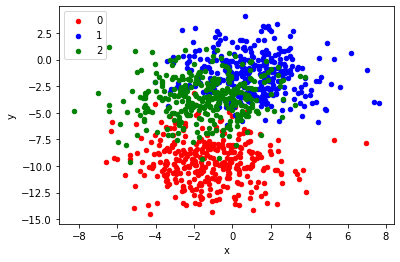

In [3]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(
        ax=ax,
        kind='scatter',
        x='x', y='y',
        label=key,
        color=colors[key]
    )
    
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line) causing many ambiguous points.

**This is desirable as it means that the problem is non-trivial and will allow a neural network model to find many different “good enough” candidate solutions, resulting in a high variance.**

<a id='sect3'></a>
## <font color='darkblue'>Multilayer Perceptron Model</font>
Before we define a model, we need to contrive a problem that is appropriate for the stacking ensemble.

In our problem, the training dataset is relatively small. Specifically, there is a 10:1 ratio of examples in the training dataset to the holdout dataset. This mimics a situation where we may have a vast number of unlabeled examples and a small number of labeled examples with which to train a model.

We will create 1,100 data points from the blobs problem. **The model will be trained on the first 100 points and the remaining 1,000 will be held back in a test dataset, unavailable to the model.**

The problem is a multi-class classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, we must one hot encode the class values before we split the rows into the train and test datasets. We can do this using the Keras [to_categorical()](https://keras.io/api/utils/python_utils/#tocategorical-function) function.

In [4]:
# generate 2d classification dataset
X, y = make_blobs(
    n_samples=1100, 
    centers=3,
    n_features=2,
    cluster_std=2,
    random_state=2
)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


In [5]:
y[:4]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

Next, we can define and combine the model.

The model will expect samples with two input variables. The model then has a single hidden layer with 25 nodes and a [**rectified linear activation function**](https://keras.io/api/layers/activations/#relu-function), then an output layer with three nodes to predict the probability of each of the three classes and a softmax activation function.

Because the problem is multi-class, we will use the categorical cross entropy loss function to optimize the model and the efficient [Adam flavor of stochastic gradient descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).

In [6]:
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for 500 training epochs and we will evaluate the model each epoch on the test set, using the test set as a validation set.

In [7]:
# fit model
history = model.fit(
    trainX, 
    trainy, 
    validation_data=(testX, testy), 
    epochs=500, 
    verbose=0
)

At the end of the run, we will evaluate the performance of the model on the train and test sets:

In [8]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.840, Test: 0.804


Then finally, we will plot learning curves of the model accuracy over each training epoch on both the training and validation datasets.

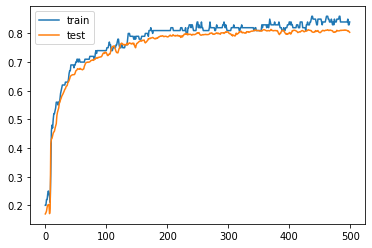

In [9]:
# learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In this case, we can see that **the model achieved about 85% accuracy on the training dataset, which we know is optimistic, and about 80% on the test dataset**, which we would expect to be more realistic.

We can now look at using instances of this model as part of a stacking ensemble.

<a id='sect4'></a>
## <font color='darkblue'>Train and Save Sub-Models</font>
<font size='3ptx'>**To keep this example simple, we will use multiple instances of the same model as level-0 or sub-models in the stacking ensemble. We will also use a holdout validation dataset to train the level-1 or meta-learner in the ensemble.**</font>

A more advanced example may use different types of MLP models (<font color='brown'>deeper, wider, etc.</font>) as sub-models and train the meta-learner using [k-fold cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/). In this section, we will train multiple sub-models and [save them to file for later use](https://machinelearningmastery.com/save-load-keras-deep-learning-models/) in our stacking ensembles.

The first step is to create a function that will define and fit an MLP model on the training dataset.

In [59]:
import os
import numpy as np
import shutil
from keras.models import load_model
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

SUB_MODELS_PATH = "models"

In [10]:
# fit model on dataset
def fit_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    model.fit(trainX, trainy, epochs=500, verbose=0)
    return model

Next, we can create a sub-directory to store the models.

Note, if the directory already exists, you may have to delete it when re-running this code.

In [16]:
# create directory for models

if os.path.isdir(SUB_MODELS_PATH):
    shutil.rmtree(SUB_MODELS_PATH)
    
os.makedirs('models')

Finally, we can create multiple instances of the MLP and save each to the "<font color='olive'>models/</font>" subdirectory with a unique filename. **In this case, we will create five sub-models, but you can experiment with a different number of models and see how it impacts model performance.**

In [17]:
# fit and save models
n_members = 5
for i in range(n_members):
    # fit model
    model = fit_model(trainX, trainy)
    # save model
    filename = 'models/model_' + str(i + 1) + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)

>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5


Running the example creates the “<font color='olive'>models/</font>” subfolder and saves five trained models with unique filenames. **Next, we can look at training a meta-learner to make best use of the predictions from these submodels.**

## <font color='darkblue'>Separate Stacking Model</font>
<font size='3ptx'>**We can now train a meta-learner that will best combine the predictions from the sub-models and ideally perform better than any single sub-model.**</font>

The first step is to load the saved models. We can use the [load_model()](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) Keras function and create a Python list of loaded models.

In [23]:
# load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models/model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

We can call this function to load our five saved models from the “<font color='olive'>models/</font>” sub-directory.

In [24]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models


**It would be useful to know how well the single models perform on the test dataset as we would expect a stacking model to perform better.** We can easily evaluate each single model on the training dataset and establish a baseline of performance

In [52]:
# evaluate standalone models on test dataset
best_perf_of_single_member = 0
for model in members:
    #testy_enc = to_categorical(testy)
    _, acc = model.evaluate(testX, testy, verbose=0)
    print('Model Accuracy: %.3f' % acc)
    if acc > best_perf_of_single_member:
        best_perf_of_single_member = acc

Model Accuracy: 0.797
Model Accuracy: 0.804
Model Accuracy: 0.814
Model Accuracy: 0.813
Model Accuracy: 0.808


Next, we can train our meta-learner. This requires two steps:
* Prepare a training dataset for the meta-learner.
* Use the prepared training dataset to fit a meta-learner model.

**We will prepare a training dataset for the meta-learner by providing examples from the test set to each of the submodels and collecting the predictions**. In this case, each model will output three predictions for each example for the probabilities that a given example belongs to each of the three classes. Therefore, the 1,000 examples in the test set will result in five arrays with the shape \[1000, 3\].

We can combine these arrays into a three-dimensional array with the shape \[1000, 5, 3\] by using the [dstack()](https://numpy.org/doc/stable/reference/generated/numpy.dstack.html) NumPy function that will stack each new set of predictions.

As input for a new model, we will require 1,000 examples with some number of features. Given that we have five models and each model makes three predictions per example, then we would have 15 (3 x 5) features for each example provided to the submodels. We can transform the \[1000, 5, 3\] shaped predictions from the sub-models into a \[1000, 15\] shaped array to be used to train a meta-learner using the reshape() NumPy function and flattening the final two dimensions. The <font color='blue'>stacked_dataset()</font> function implements this step.

In [28]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
            
    print(f"stackX with shape as {stackX.shape}")
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    print(f"Flatterned stackX with shape as {stackX.shape}")
    return stackX

Once prepared, we can use this input dataset along with the output, or y part, of the test set to train a new meta-learner.

In this case, we will train a simple logistic regression algorithm from the scikit-learn library.

[**Logistic regression**](https://machinelearningmastery.com/logistic-regression-for-machine-learning/) only supports binary classification, although the implementation of logistic regression in scikit-learn in the [**LogisticRegression**](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class supports multi-class classification (<font color='brown'>more than two classes</font>) using a one-vs-rest scheme. The function <font color='blue'>fit_stacked_model()</font> below will prepare the training dataset for the meta-learner by calling the <font color='blue'>stacked_dataset()</font> function, then fit a logistic regression model that is then returned.

In [39]:
testy[0]

array([1., 0., 0.], dtype=float32)

In [38]:
testX.shape

(1000, 2)

In [45]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LogisticRegression()
    inputy_flattern = np.argmax(inputy, axis=1)
    model.fit(stackedX, inputy_flattern)
    return model

We can call this function and pass in the list of loaded models and the training dataset.

In [46]:
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)

stackX with shape as (1000, 3, 5)
Flatterned stackX with shape as (1000, 15)


Once fit, we can use the stacked model, including the members and the meta-learner, to make predictions on new data.

This can be achieved by first using the sub-models to make an input dataset for the meta-learner, e.g. by calling the <font color='blue'>stacked_dataset()</font> function, then making a prediction with the meta-learner. The <font color='blue'>stacked_prediction()</font> function below implements this.

In [47]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

We can use this function to make a prediction on new data; in this case, we can demonstrate it by making predictions on the test set.

In [51]:
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
testy_flattern = np.argmax(testy, axis=1)
acc = accuracy_score(testy_flattern, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

stackX with shape as (1000, 3, 5)
Flatterned stackX with shape as (1000, 15)
Stacked Test Accuracy: 0.829


We can see that in this case, the meta-learner out-performed each of the sub-models on the test set, achieving an accuracy of about 82.9% (Better than the best performance among single member as 81.4%).

## <font color='darkblue'>Integrated Stacking Model</font>
<font size='3ptx'>**When using neural networks as sub-models, it may be desirable to use a neural network as a meta-learner.**</font>

Specifically, the sub-networks can be embedded in a larger multi-headed neural network that then learns how to best combine the predictions from each input sub-model. It allows the stacking ensemble to be treated as a single large model.

The benefit of this approach is that the outputs of the submodels are provided directly to the meta-learner. **Further, it is also possible to update the weights of the submodels in conjunction with the meta-learner model, if this is desirable.**

This can be achieved using the [**Keras functional interface**](https://machinelearningmastery.com/keras-functional-api-deep-learning/) for developing models.

After the models are loaded as a list, a larger stacking ensemble model can be defined where each of the loaded models is used as a separate input-head to the model. This requires that all of the layers in each of the loaded models be marked as not trainable so the weights cannot be updated when the new larger model is being trained. Keras also requires that each layer has a unique name, therefore the names of each layer in each of the loaded models will have to be updated to indicate to which ensemble member they belong.
```python
# update all layers in all models to not be trainable
for i in range(len(members)):
	model = members[i]
	for layer in model.layers:
		# make not trainable
		layer.trainable = False
		# rename to avoid 'unique layer name' issue
		layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
```

Once the sub-models have been prepared, we can define the stacking ensemble model.

The input layer for each of the sub-models will be used as a separate input head to this new model. This means that `k` copies of any input data will have to be provided to the model, where `k` is the number of input models, in this case, 5.

The outputs of each of the models can then be merged. In this case, we will use a simple concatenation merge, where a single 15-element vector will be created from the three class-probabilities predicted by each of the 5 models.

We will then define a hidden layer to interpret this “input” to the meta-learner and an output layer that will make its own probabilistic prediction. **The <font color='blue'>define_stacked_model()</font> function below implements this and will return a stacked generalization neural network model given a list of trained sub-models.**

In [53]:
# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(3, activation='softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
    plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

A plot of the network graph is created when this function is called to give an idea of how the ensemble model fits together.

In [60]:
# define ensemble model
stacked_model = define_stacked_model(members)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


Creating the plot requires that pygraphviz is installed. 

Once the model is defined, it can be fit. We can fit it directly on the holdout test dataset.

**Because the sub-models are not trainable, their weights will not be updated during training and only the weights of the new hidden and output layer will be updated.** The <font color='blue'>fit_stacked_model()</font> function below will fit the stacking neural network model on for 300 epochs.

In [64]:
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # encode output data
    # inputy_enc = to_categorical(inputy)
    # fit model
    model.fit(X, inputy, epochs=300, verbose=0)

We can call this function providing the defined stacking model and the test dataset.

In [65]:
# fit stacked model on test dataset
fit_stacked_model(stacked_model, testX, testy)

Once fit, we can use the new stacked model to make a prediction on new data.

This is as simple as calling the <font color='blue'>predict()</font> function on the model. One minor change is that we require `k` copies of the input data in a list to be provided to the model for each of the `k` sub-models. The <font color='blue'>predict_stacked_model()</font> function below simplifies this process of making a prediction with the stacking model.

In [66]:
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(X, verbose=0)

We can call this function to make a prediction for the test dataset and report the accuracy.

We would expect the performance of the neural network learner to be better than any individual submodel and perhaps competitive with the linear meta-learner used in the previous section.

In [71]:
yans = np.argmax(testy, axis=1)
yans.shape

(1000,)

In [72]:
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, testX)
yhat = np.argmax(yhat, axis=1)
acc = accuracy_score(yans, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Stacked Test Accuracy: 0.835


A larger stacking ensemble neural network is defined and fit on the test dataset, then the new model is used to make a prediction on the test dataset. We can see that, **in this case, the model achieved an accuracy of about 83.5%, out-performing the linear model from the previous section.**

## <font color='darkblue'>Extensions</font>
This section lists some ideas for extending the tutorial that you may wish to explore.
* **Alternate Meta-Learner**. Update the example to use an alternate meta-learner classifier model to the logistic regression model.
* **Single Level 0 Model**. Update the example to use a single level-0 model and compare the results.
* **Vary Level 0 Models**. Develop a study that demonstrates the relationship between test classification accuracy and the number of sub-models used in the stacked ensemble.
* **Cross-Validation Stacking Ensemble**. Update the example to use k-fold cross-validation to prepare the training dataset for the meta-learner model.
* **Use Raw Input in Meta-Learner**. Update the example so that the meta-learner algorithms take the raw input data for the sample as well as the output from the sub-models and compare performance.

## <font color='darkblue'>Further Reading</font>
This section provides more resources on the topic if you are looking to go deeper.

### <font color='darkgreen'>Books</font>
* Section 8.8 Model Averaging and Stacking, [The Elements of Statistical Learning: Data Mining, Inference, and Prediction, Second Edition, 2016.](https://amzn.to/2DYeHAO)
* Section 7.5 Combining multiple models, [Data Mining: Practical Machine Learning Tools and Techniques, Second Edition, 2005.](https://amzn.to/2pBxIPN)
* Section 9.8.2 Stacked Generalization, [Neural Networks for Pattern Recognition, 1995.](https://amzn.to/2pAQAOR)

### <font color='darkgreen'>Papers</font>
* [Stacked generalization, 1992.](https://www.sciencedirect.com/science/article/pii/S0893608005800231)
* [Issues in Stacked Generalization, 1999.](https://www.jair.org/index.php/jair/article/view/10228)

### <font color='darkgreen'>API</font>
* [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/)
* [Keras Core Layers API](https://keras.io/layers/core/)
* [numpy.argmax API](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html)
* [sklearn.datasets.make_blobs API](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)
* [numpy.dstack API](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html)
* [sklearn.linear_model.LogisticRegression API](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

### <font color='darkgreen'>Articles</font>
* [Stacked Generalization (Stacking) Bibliography.](http://machine-learning.martinsewell.com/ensembles/stacking/)
* [Ensemble learning, Wikipedia.](https://en.wikipedia.org/wiki/Ensemble_learning)

### <font color='darkgreen'>Posts</font>
* [How to Implement Stacked Generalization From Scratch With Python](https://machinelearningmastery.com/implementing-stacking-scratch-python/)

## <font color='darkblue'>Supplement</font>
* [FAQ - Keras to_categorical how to reverse it](https://github.com/keras-team/keras/issues/4981)
> The inverse of to_categorical is np.argmax or K.argmax.